In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from resnet import resnet18, resnet34, resnet50
from vgg import vgg16
from deepdream2 import dream

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
input_img = Image.open('./Images/algues.jpg')
input_tensor = img_transform(input_img).unsqueeze(0)
input_np = input_tensor.numpy()

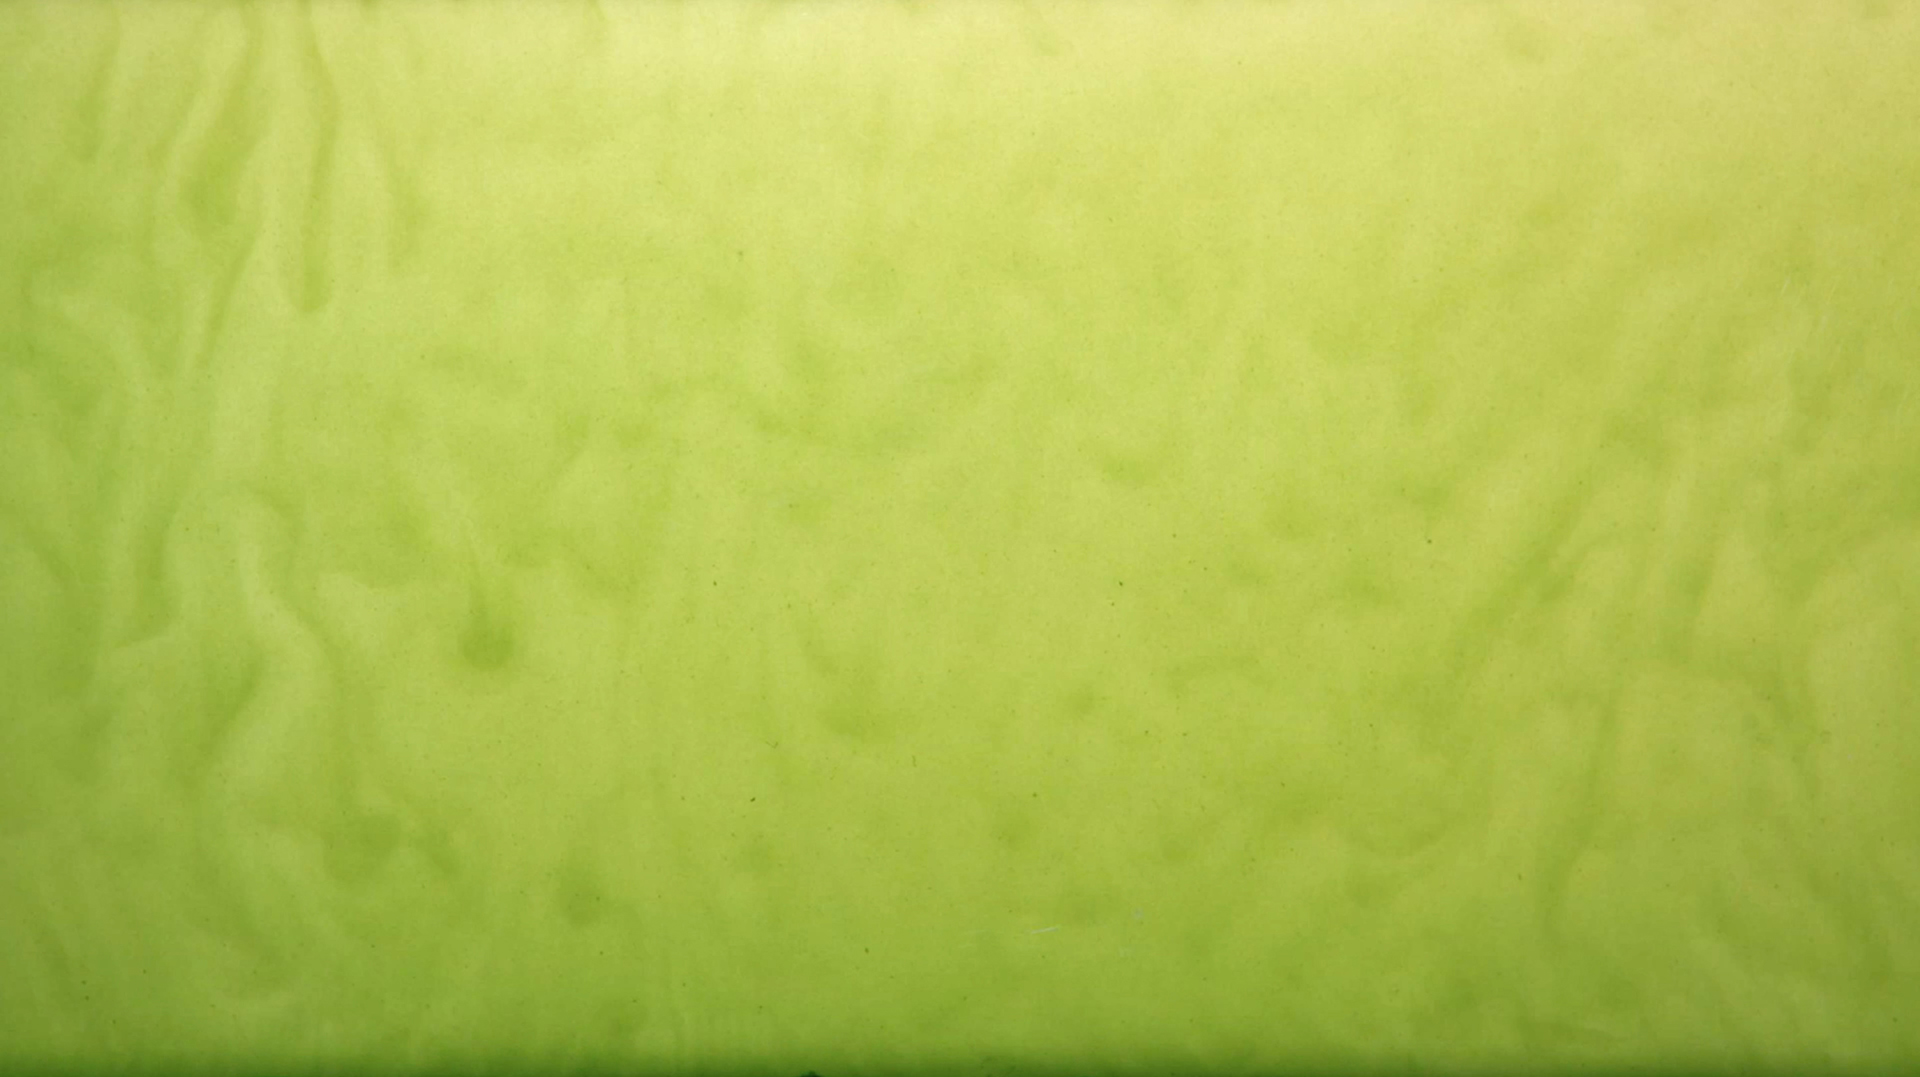

In [4]:
input_img

In [5]:
# load model (only resnet 18, 34 and 50 available at the moment)
# model = resnet50(pretrained=True)
model = resnet18(pretrained=True)

if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

In [6]:
octave_n=4 # default is 4
octave_scale=1.25 # default is 1.4
end_layer=3 # default is 3
learning_rate = 2e-2 # default is 2e-2, play carefully with this one
max_jitter = 64 # default is 31
num_iterations = 16 # default is 20
show_every = 8 # default is 10

dream(model, input_np, octave_n=octave_n, octave_scale=octave_scale, end_layer=end_layer, learning_rate=learning_rate, max_jitter=max_jitter, num_iterations=num_iterations, show_every=show_every)

KeyboardInterrupt: 

## Control the dream

In [7]:
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import transforms
import os
from resnet import resnet18, resnet34, resnet50
from deepdream import dream
from PIL import Image
from util import showtensor

In [8]:
img_transform = transforms.Compose([
        #transforms.CenterCrop(224),
        #transforms.Scale(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
inputs_control = Image.open('./Images/guide_image/poisson_rouge.jpg')
inputs_control = img_transform(inputs_control).unsqueeze(0)
inputs_control_np = inputs_control.numpy()

AttributeError: module 'torchvision.transforms' has no attribute 'Resize'

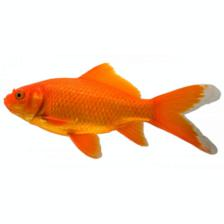

In [9]:
showtensor(inputs_control_np)

In [10]:
model = resnet18(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

if torch.cuda.is_available():
    x_variable = Variable(inputs_control.cuda())
else:
    x_variable = Variable(inputs_control)

control_features = model.forward(x_variable, end_layer=3)

In [11]:
def objective_guide(dst, guide_features):
    x = dst.data[0].cpu().numpy().copy()
    y = guide_features.data[0].cpu().numpy()
    ch, w, h = x.shape
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float))
    
    if torch.cuda.is_available():
        result = result.cuda()
    
    return result

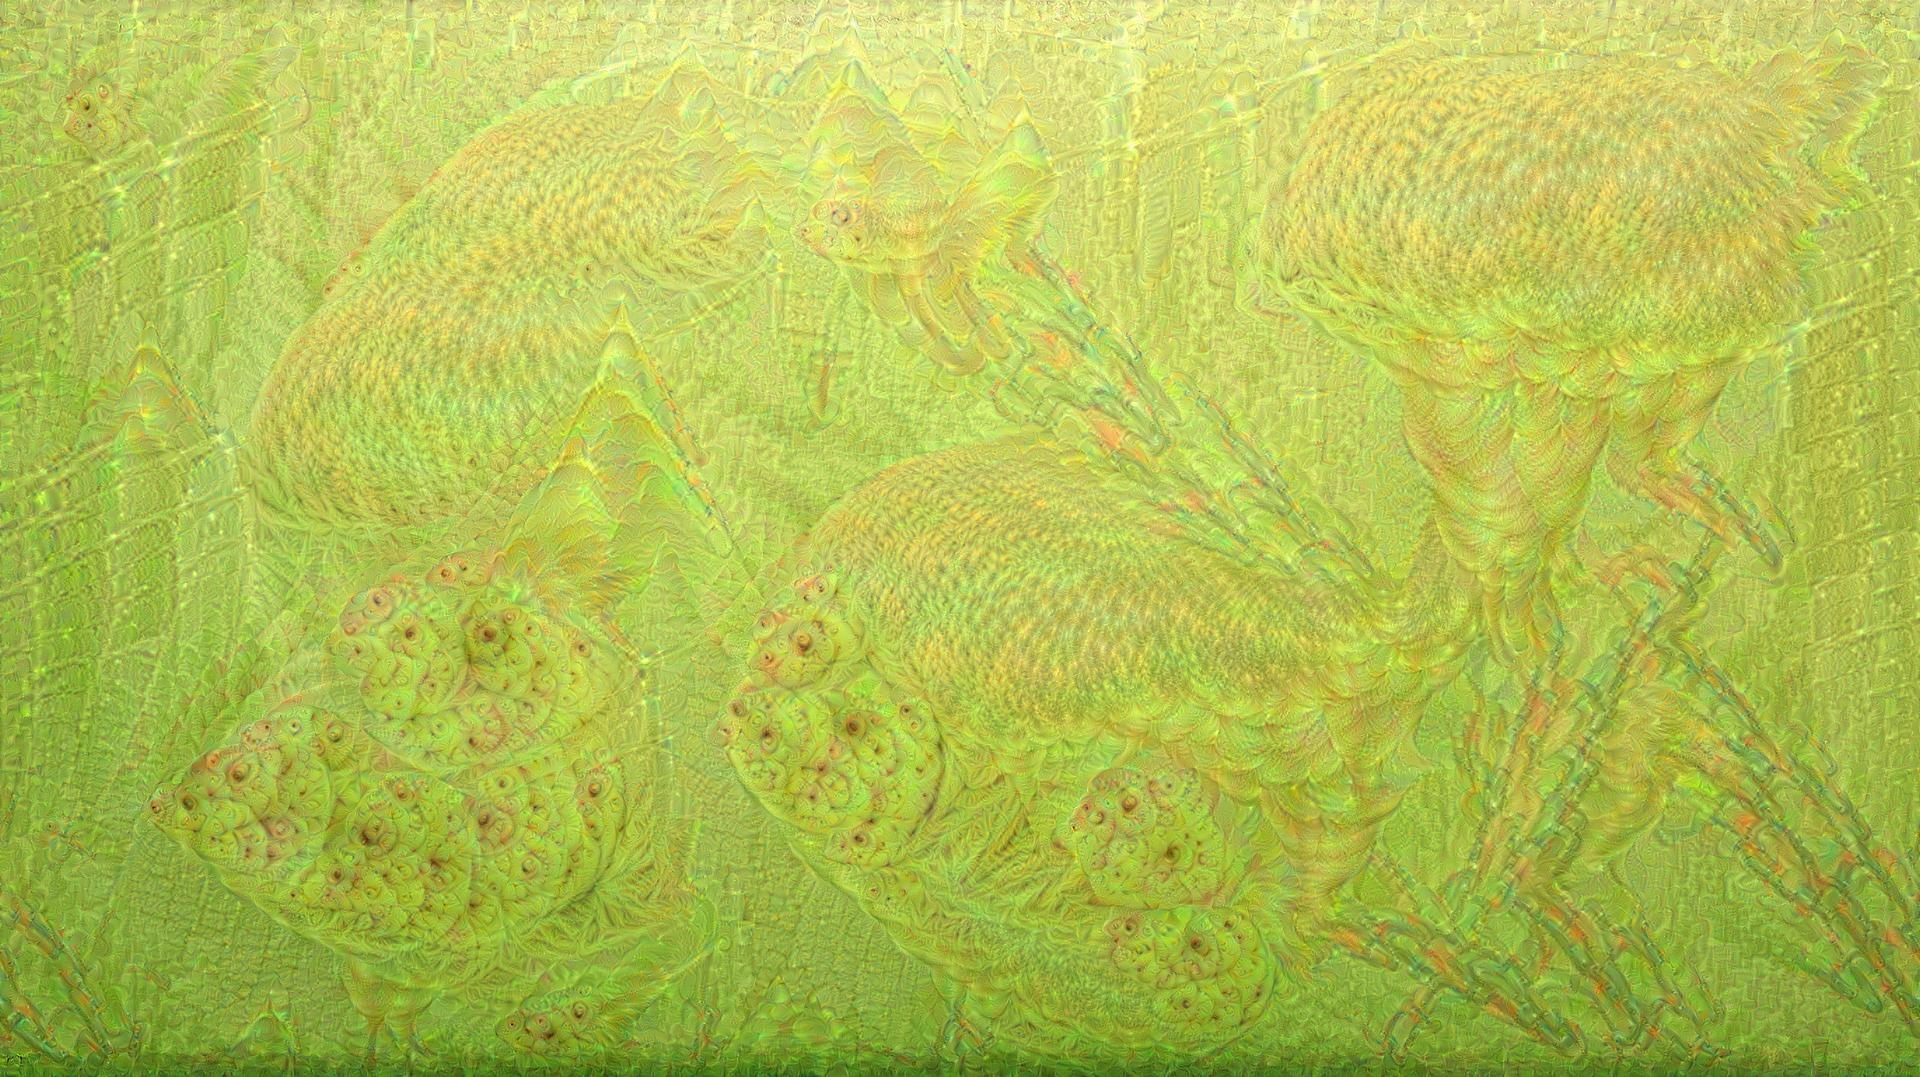

In [12]:
octave_number=6
octave_scale=1.4
learning_rate = 2e-2 # don't change the value from 2e-2, unless you know what you are doing
max_jitter = 32
num_iterations = 20
show_every = 10
end_layer = 3

dream(model, 
      input_np, 
      control=control_features,
      distance=objective_guide,
      octave_n=octave_number,
      octave_scale=octave_scale,
      learning_rate = learning_rate,
      max_jitter = max_jitter,
      num_iterations = num_iterations,
      show_every = show_every,
      end_layer = end_layer
     )